In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

2025-05-19 02:13:07.220298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 02:13:07.531855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sklearn: 1.5.1
tensorflow: 2.18.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[]


In [3]:
train_model = True
run_grid_search = True
save_model = True

model_path = "keras_model.keras"
scaler_path = "standard_scaler.joblib"

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:50000])]))[:, 1]
    reorder_valid = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[50000:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:50000] = mnist.data[reorder_train]
    mnist.target[:50000] = mnist.target[reorder_train]
    mnist.data[50000:60000] = mnist.data[reorder_valid + 50000]
    mnist.target[50000:60000] = mnist.target[reorder_valid + 50000]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:50000]
y_train = mnist.target[:50000]
X_valid_raw = mnist.data[50000:60000]
y_valid = mnist.target[50000:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_valid_raw.shape )
print ( X_test_raw.shape )

(50000, 784)
(10000, 784)
(10000, 784)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_valid = scaler.transform( X_valid_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
    dump( scaler, scaler_path )

StandardScaler()


9
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00483977 -0.00630411 -0.00447218 -0.00447218  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00447218 -0.00515922 -0.00963928 -0.01211949
 -0.01436819 -0.01737385 -0.02270852 -0.02757692 -0.02980096 -0.03081968
 -0.03110097 -0.03015775 -0.03021858 -0.02670023 -0.02103146 -0.01838468
 -0.0166327  -0.01131016 -0.00800445 -0.00479882  0.          0.
  0.          0.          0.          0.         -0.00447218 -0.00447218
 -0.00889745 -0.01236598 -0.01790015 -0.02738895 -0.0371536  -0.05175937
 -0.06602942 -0.082747   -0.10052937 -0.11606085 -0.12843945 -0.13638324
 -0.13592586 -0.1297393  -0.11885722 -0.10081914 -0.07808218 -0.05640676
 -0.03917999 -0.02442581 -0.01543332 -0.00857831  0.          0.
  0.          0.         -0.0048

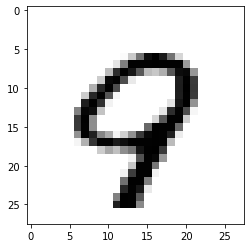

In [6]:
idx = 9900
print ( y_valid[ idx ] )
print ( X_valid[ idx ] )

fig = plt.figure( figsize=(4,4) )
plt.imshow( X_valid_raw[ idx ].reshape(28,28), cmap='binary' )

In [7]:
shuffle_index = np.random.permutation( 50000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]
print ( X_train_shuffle )
print ( y_train_shuffle )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0 2 6 ... 0 3 3]


In [8]:
class HyperModel:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, n_hidden, n_neurons, dropout):
        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )

        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(10, activation="softmax") )

        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

def build_model(input_shape, learning_rate=5e-4, n_hidden=1, n_neurons=50, dropout=0.20 ):
    hypermodel_ = HyperModel( input_shape=input_shape, learning_rate=learning_rate )
    return hypermodel_.build( n_hidden, n_neurons, dropout )

In [9]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_

In [10]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=5e-4,
    n_hidden=2,
    n_neurons=20,
    dropout=0.10
    )
model.summary()

Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.1


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,330 (63.79 KB)

 Trainable params: 16,330 (63.79 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks_ = callbacks( patience=3 )
epochs_ = 20
batch_size_ = 32
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, 
                    batch_size=batch_size_, validation_data=(X_valid, y_valid), 
                    callbacks=callbacks_ )

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6667 - loss: 1.0859 - val_accuracy: 0.9191 - val_loss: 0.3141
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8780 - loss: 0.4096 - val_accuracy: 0.9340 - val_loss: 0.2572
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.3540 - val_accuracy: 0.9401 - val_loss: 0.2295
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9059 - loss: 0.3157 - val_accuracy: 0.9421 - val_loss: 0.2109
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9109 - loss: 0.2940 - val_accuracy: 0.9428 - val_loss: 0.2031
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9150 - loss: 0.2824 - val_accuracy: 0.9467 - val_loss: 0.1853
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9195 - loss: 0.2600 - val_accuracy: 0.9473 - val_loss: 0.1829
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9223 - loss: 0.2551 - 

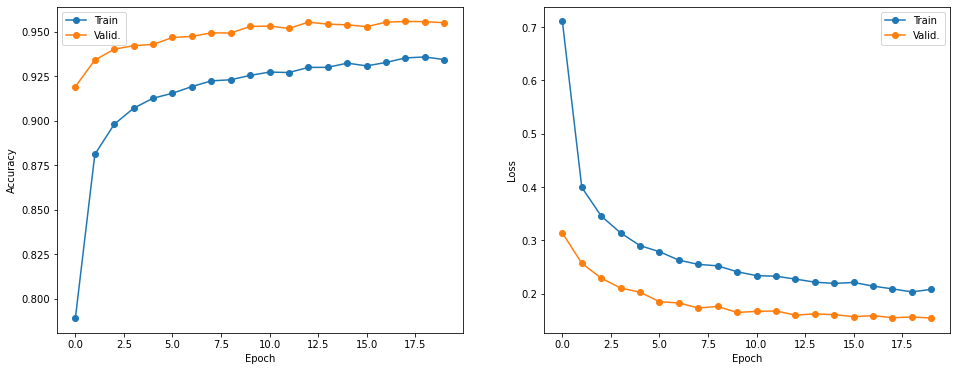

In [12]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [13]:
model.evaluate( X_train, y_train ) # without dropout

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9757 - loss: 0.0803


[0.1095837727189064, 0.9664999842643738]

In [14]:
model.evaluate( X_valid, y_valid )

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9654 - loss: 0.1131


[0.1547759622335434, 0.9549999833106995]

In [15]:
def find_max_learning_rate( X, y, X_val, y_val, lr_init=1e-4, lr_end=5e-2, steps=20, epochs=20, model_build_fn=build_model, callback_fn=callbacks, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callback_fn(patience=3)
        history_ = model_.fit( X, y, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_

    return results_

In [16]:
learning_rate_scan = True
epochs_lr_scan = 20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                X_train_shuffle, y_train_shuffle,
                X_valid, y_valid,
                lr_init=1e-4,
                lr_end=2e-2,
                steps=5,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                input_shape=X_train_shuffle.shape[1:],
                n_hidden=2,
                n_neurons=20,
                dropout=0.,
                )

Building model with:
Input shape: (784,)
Learning rate: 0.0001
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5700 - loss: 1.4340 - val_accuracy: 0.8843 - val_loss: 0.4510
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8742 - loss: 0.4538 - val_accuracy: 0.9131 - val_loss: 0.3189
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9077 - loss: 0.3350 - val_accuracy: 0.9260 - val_loss: 0.2689
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9223 - loss: 0.2728 - val_accuracy: 0.9326 - val_loss: 0.2410
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9283 - loss: 0.2442 - val_accuracy: 0.9387 - val_loss: 0.2236
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9369 - loss: 0.2208 - val_accuracy: 0.9422 - val_loss: 0.2118
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9404 - loss:

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9703 - loss: 0.0938 - val_accuracy: 0.9584 - val_loss: 0.1700
Building model with:
Input shape: (784,)
Learning rate: 0.0069314484315514645
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8638 - loss: 0.4852 - val_accuracy: 0.9404 - val_loss: 0.2174
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9353 - loss: 0.2275 - val_accuracy: 0.9415 - val_loss: 0.2056
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9420 - loss: 0.2027 - val_accuracy: 0.9401 - val_loss: 0.2273
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9453 - loss: 0.1879 - val_accuracy: 0.9459 - val_loss: 0.2155
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9483 - loss: 0.1792 - val_accuracy: 0.9473 - val_loss: 0.2006
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9515 - l

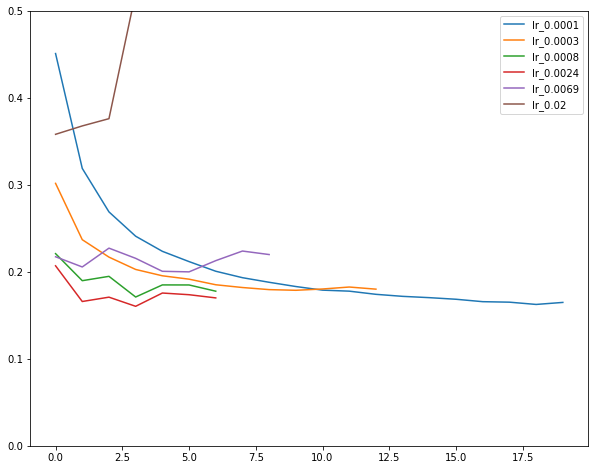

In [17]:
if learning_rate_scan:
    # metrics_ = 'loss'
    metrics_ = 'val_loss'
    # metrics_ = 'val_accuracy'
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,len(columns_)),np.nan), columns=columns_ )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[col_] = pd.Series( results[ metrics_ ][i_lr_] )
        df_[col_].plot()
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )
    # plt.ylim( 0.80, 1.05 )

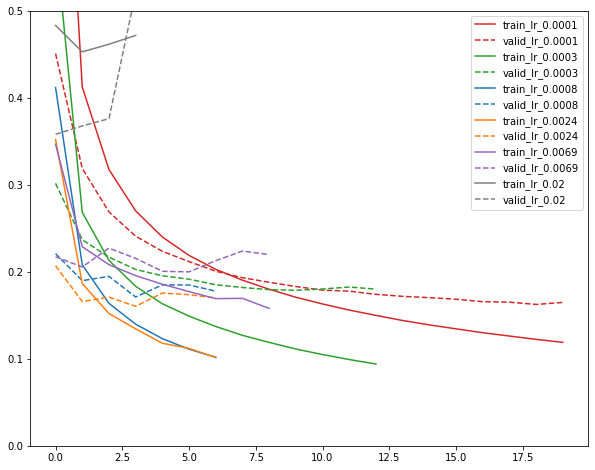

In [18]:
if learning_rate_scan:
    metrics_train_ = 'loss'
    metrics_valid_ = 'val_loss'
    colors_=['tab:red','tab:green','tab:blue','tab:orange', 'tab:purple', 'tab:gray']
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,2*len(columns_)),np.nan), columns=( 2 * columns_ ) )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[ "train_{}".format( col_ ) ] = pd.Series( results[ metrics_train_ ][i_lr_] )
        df_[ "train_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ] )
        df_[ "valid_{}".format( col_ ) ] = pd.Series( results[ metrics_valid_ ][i_lr_] )
        df_[ "valid_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ], linestyle='dashed' )
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )

In [19]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

(1e-05, 0.02)

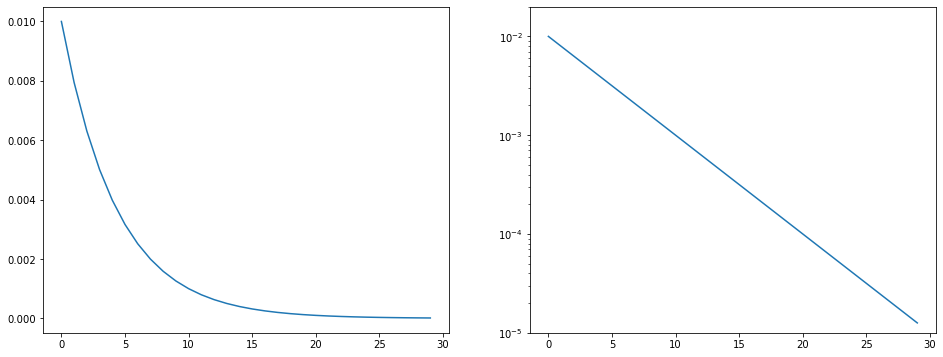

In [20]:
exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
xplot__ = np.arange(30)
axes[0].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].set_yscale( 'log' )
axes[1].set_ylim( 1e-5, 2e-2 )

In [21]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=1e-2,
    n_hidden=2,
    n_neurons=20,
    dropout=0.10
    )

callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )
epochs_ = 20
batch_size_ = 32
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size_, 
                    validation_data=(X_valid, y_valid), callbacks=callbacks_ )

Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.1


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8049 - loss: 0.6912 - val_accuracy: 0.9165 - val_loss: 0.2755 - learning_rate: 0.0100
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8771 - loss: 0.4182 - val_accuracy: 0.9306 - val_loss: 0.2448 - learning_rate: 0.0079
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8923 - loss: 0.3647 - val_accuracy: 0.9389 - val_loss: 0.2162 - learning_rate: 0.0063
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9037 - loss: 0.3309 - val_accuracy: 0.9419 - val_loss: 0.1987 - learning_rate: 0.0050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9132 - loss: 0.2984 - val_accuracy: 0.9441 - val_loss: 0.1965 - learning_rate: 0.0040
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9175 - loss: 0.2795 - val_accuracy: 0.9495 - val_loss: 0.1756 - learning_rate: 0.0032
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9235 - l

In [22]:
history.history

{'accuracy': [0.8443999886512756,
  0.8807200193405151,
  0.8941199779510498,
  0.9035599827766418,
  0.9118000268936157,
  0.9179999828338623,
  0.9222800135612488,
  0.9264799952507019,
  0.9282799959182739,
  0.9316999912261963,
  0.9337400197982788,
  0.9344599843025208,
  0.9352200031280518,
  0.9370399713516235,
  0.938979983329773,
  0.9376599788665771,
  0.940339982509613,
  0.9399200081825256,
  0.9390400052070618,
  0.9409000277519226],
 'loss': [0.5350028872489929,
  0.4051683247089386,
  0.35925766825675964,
  0.33134499192237854,
  0.30313846468925476,
  0.2785566747188568,
  0.2609524726867676,
  0.24619506299495697,
  0.23640809953212738,
  0.23020943999290466,
  0.22034867107868195,
  0.21670734882354736,
  0.21105888485908508,
  0.20487800240516663,
  0.20182214677333832,
  0.20330356061458588,
  0.19739796221256256,
  0.19989070296287537,
  0.2039252370595932,
  0.1962561309337616],
 'val_accuracy': [0.9164999723434448,
  0.9305999875068665,
  0.9388999938964844,
  0.

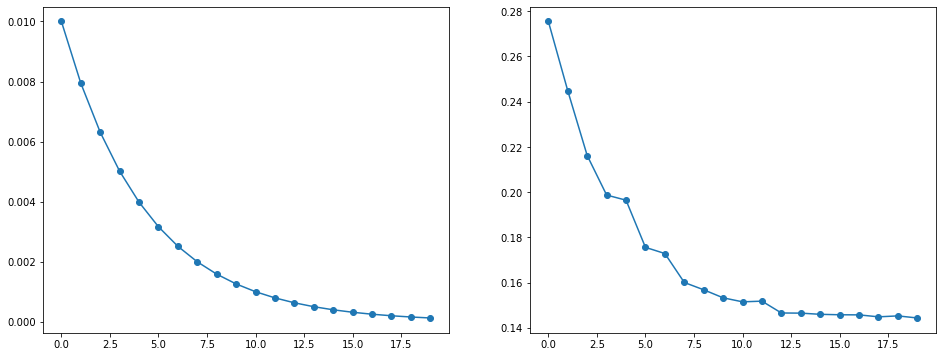

In [23]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['learning_rate'], 'o-' )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-' )

In [24]:
import keras_tuner as kt

class HyperModel(kt.HyperModel):
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, hp):
        n_hidden = hp.Int( "n_hidden", min_value=1, max_value=6 )
        n_neurons = hp.Choice( "n_neurons", ( 2 ** np.arange(4,8) ).tolist() )
        dropout = hp.Choice("dropout", ( 0.1 * np.arange(1,6) ).tolist() )

        print( "Building model with:" )
        print( "Input shape: {}".format(self.input_shape) )
        print( "Learning rate: {}".format(self.learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )

        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=self.input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(10, activation="softmax") )

        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=self.learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size_ = hp.Choice( "batch_size", ( 2 ** np.arange(5,8) ).tolist() )
        print( "Batch size: {}".format( batch_size_ ) )
        return model.fit(
            *args,
            batch_size=batch_size_,
            **kwargs,
        )

In [25]:
epochs_ = 20

n_hidden_ = 2
n_neurons_ = 20
dropout_ = 0.20
batch_size_ = 32

hp = kt.HyperParameters()
hp.values = { "n_hidden": n_hidden_, "n_neurons": n_neurons_, "dropout": dropout_, "batch_size": batch_size_ }
print ( hp.values )

hypermodel = HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
model = hypermodel.build(hp)
callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )

hypermodel.fit(hp, model, X_train_shuffle, y_train_shuffle, epochs=epochs_, 
               validation_data=(X_valid, y_valid), callbacks=callbacks_ )

{'n_hidden': 2, 'n_neurons': 20, 'dropout': 0.2, 'batch_size': 32}
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.2
Batch size: 32
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7486 - loss: 0.8658 - val_accuracy: 0.9068 - val_loss: 0.3129 - learning_rate: 0.0100
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8384 - loss: 0.5431 - val_accuracy: 0.9225 - val_loss: 0.2617 - learning_rate: 0.0079
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8530 - loss: 0.4946 - val_accuracy: 0.9252 - val_loss: 0.2580 - learning_rate: 0.0063
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8653 - loss: 0.4605 - val_accuracy: 0.9358 - val_loss: 0.2273 - learning_rate: 0.0050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8758 - loss: 0.4370 - val_accuracy: 0.9342 - val_loss: 0.2202 - learning_rate: 0.0040
Epoch 6/20

In [26]:
n_iter_search = 5
epochs_grid_search = 10

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )
    print ( callbacks_ )

    tuner = kt.RandomSearch(
        HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 ),
        objective="val_accuracy",
        max_trials=n_iter_search,
        executions_per_trial=3,
        overwrite=True,
        directory="tuner",
        project_name="ann_hypermodel"
    )
    print ( tuner.search_space_summary() )

    tuner.search( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

Trial 5 Complete [00h 01m 39s]
val_accuracy: 0.9272333383560181

Best val_accuracy So Far: 0.9709999958674113
Total elapsed time: 00h 10m 10s
Total time elapsed: 610


In [27]:
hp = tuner.get_best_hyperparameters()[0]
hp.values

{'n_hidden': 3, 'n_neurons': 128, 'dropout': 0.1, 'batch_size': 32}

In [28]:
model_final = None
history = None

if train_model:
    hp = None
    params = None
    if run_grid_search:
        hp = tuner.get_best_hyperparameters()[0]
        params = hp.values
    else:
        params = { 'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20, 'batch_size': 32 }
        hp = kt.HyperParameters()
        hp.values = params
    print ( params )

    hypermodel = HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
    model_final = hypermodel.build( hp )

    log_dir="keras_logs"
    callbacks_ = callbacks(patience=3, lr_scheduler_fn=exponential_decay_, log_dir=log_dir)
    print ( callbacks_ )

    epochs_ = 50
    history = hypermodel.fit(hp, model_final, X_train_shuffle, y_train_shuffle, epochs=epochs_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

    if save_model:
        model_final.save( model_path )
else:
    model_final = keras.models.load_model( model_path )

{'n_hidden': 3, 'n_neurons': 128, 'dropout': 0.1, 'batch_size': 32}
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 3
Number of neurons per layer: 128
Dropout rate: 0.1
Log dir: keras_logs/run_2025_05_19-02_32_28
[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fc5e0f9f890>, <keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler object at 0x7fc5e16adf90>, <keras.src.callbacks.tensorboard.TensorBoard object at 0x7fc5e0fa66d0>]
Batch size: 32
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7949 - loss: 0.8499 - val_accuracy: 0.8781 - val_loss: 0.4797 - learning_rate: 0.0100
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8669 - loss: 0.5373 - val_accuracy: 0.8946 - val_loss: 0.4161 - learning_rate: 0.0079
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8850 - loss: 0.4624 - val_accuracy: 0.9261 - val_loss: 0.3042 - learning_rate: 0.0063
Epoch 4/50
1563/1563 ━━━━━━

In [29]:
model_final.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,385 (1.54 MB)

 Trainable params: 134,794 (526.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 269,591 (1.03 MB)

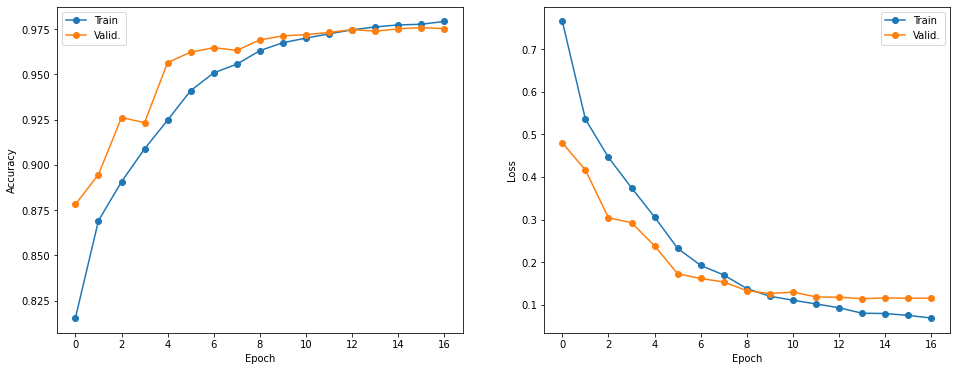

In [30]:
if history is not None:
    fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
    axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
    axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
    axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
    axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend( loc='best' )
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend( loc='best' )

In [31]:
model_final.evaluate( X_train, y_train ) # without dropout

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9905 - loss: 0.0313


[0.0369892492890358, 0.9886599779129028]

In [32]:
model_final.evaluate( X_valid, y_valid )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.0856


[0.11447342485189438, 0.973800003528595]

In [33]:
model_final.evaluate( X_test, y_test )

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.1101


[0.15766678750514984, 0.9718000292778015]

In [34]:
y_test_proba = model_final.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1.0000000e+00 1.9099720e-35 1.5495014e-26 ... 2.6198021e-26
  3.2385297e-19 7.8866111e-15]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 8.2865639e-38]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [9.6845051e-14 6.3874107e-13 5.4809715e-15 ... 3.5304200e-08
  1.3015340e-08 9.9999976e-01]
 [2.4321075e-18 7.8158238e-19 6.5331526e-20 ... 3.4013056e-11
  4.1454127e-12 1.0000000e+00]
 [1.3293873e-14 2.8338967e-15 1.7143590e-16 ... 3.8703951e-09
  1.7052628e-09 1.0000000e+00]]
[0 0 0 ... 9 9 9]


In [35]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9718


282
0: 12
1: 10
2: 29
3: 26
4: 35
5: 29
6: 17
7: 29
8: 44
9: 51


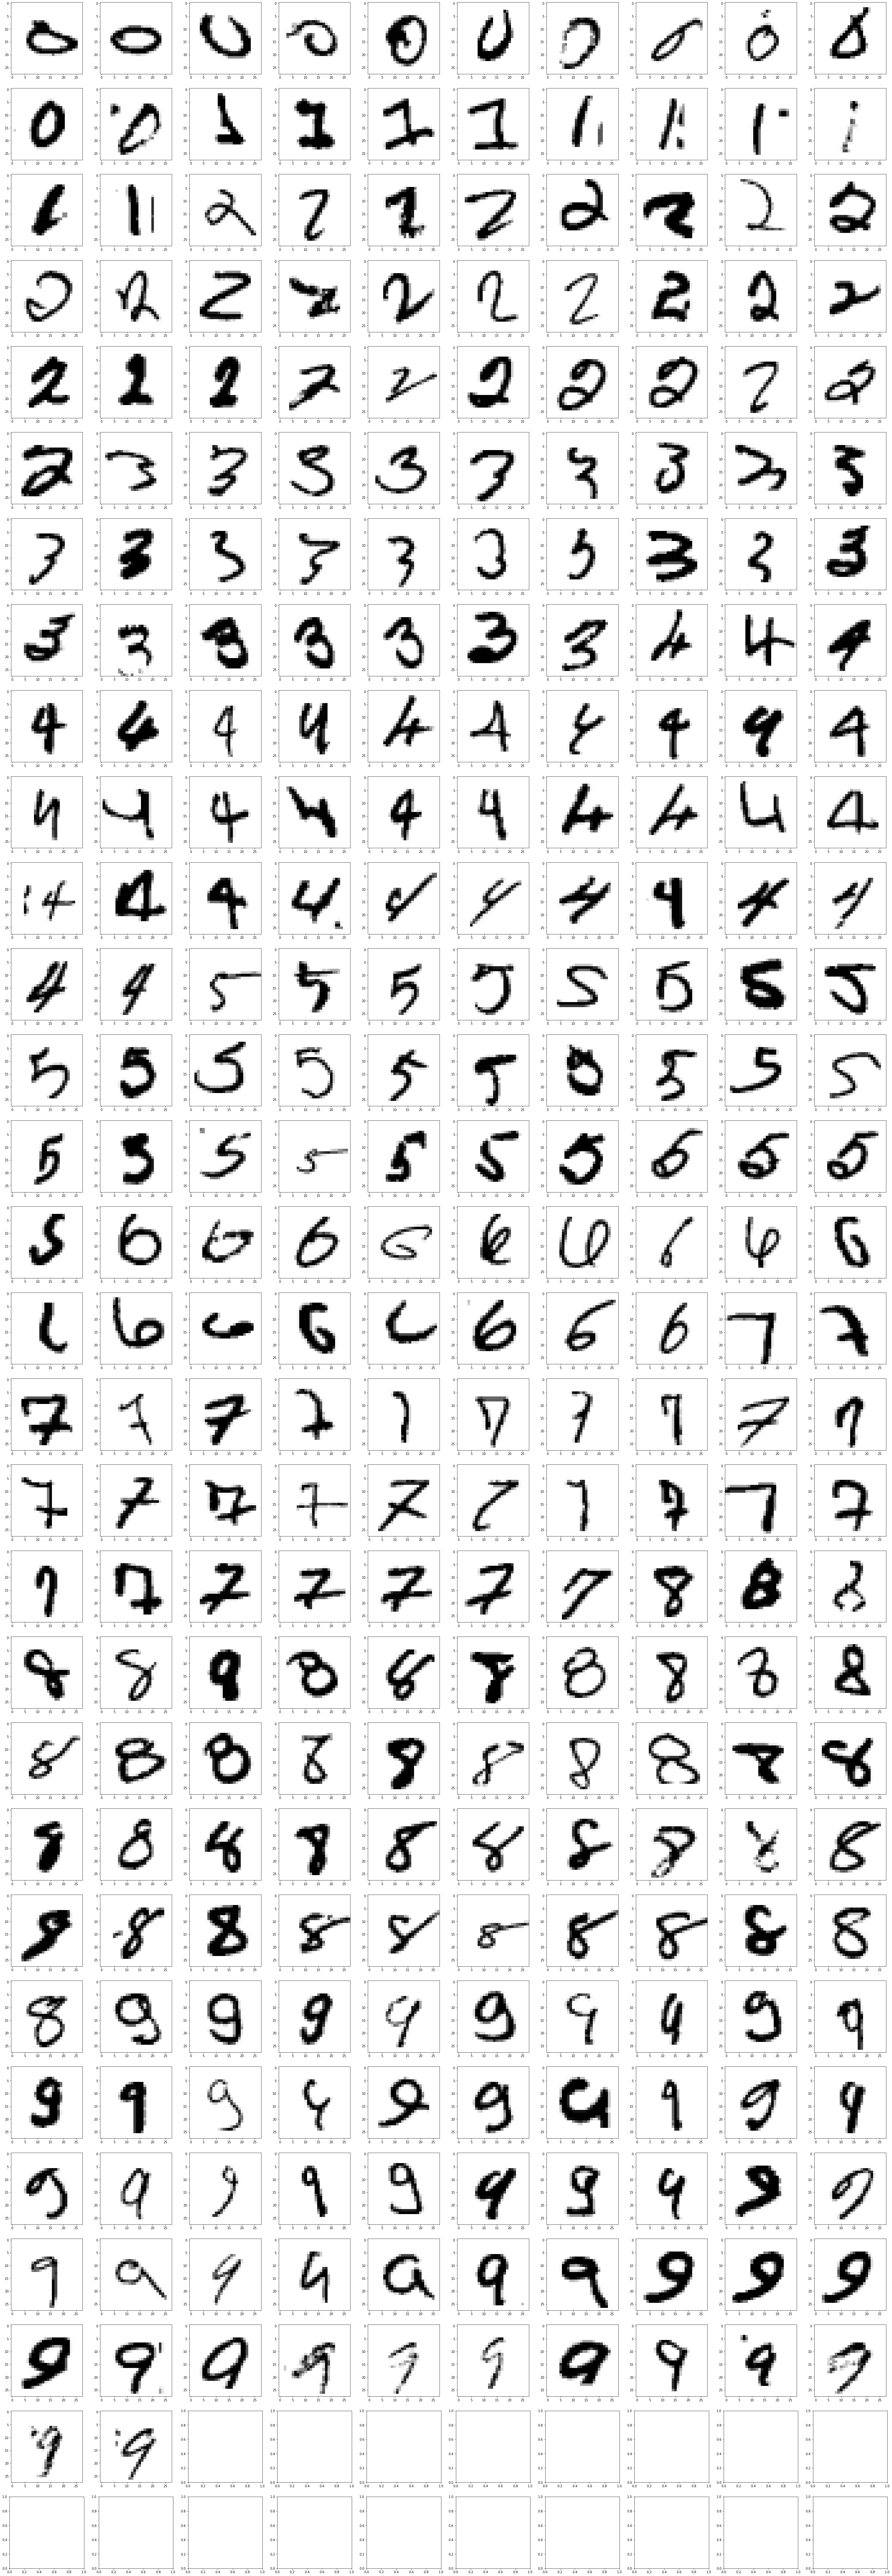

In [36]:
def plot_digits( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ].reshape(28,28), cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{}: {}".format( label_, np.sum( msk__ ) ) )

plot_digits( X_test_raw[ msk_error_ ], 300 )